<a href="https://colab.research.google.com/github/xinzhao2627/CCMACLRL_EXERCISES_COM222ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [31]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

**Validation Set**

Use this set to evaluate your model

**Test Set**
  
Use this set to test your model

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [32]:
# put your answer here
df_train.sample(10)

,text,label
13045,[USERNAME] Leni Robredo & Doc Willie Ong. Chel...,0
17015,Amber SOGIEEquality Now [USERNAME] Wala palang...,1
11182,Pagnaririnig ko talaga yung commercial ni Bina...,1
607,Mar Roxas proclaimed datu by Lanao sultanate ...,0
18913,[USERNAME] LET LEN LEAD !!!!!!,0
3433,[USERNAME] when I woke up I was shocked that s...,0
17500,"JUST IN: ""Mananalo si Mar Roxas dahil siya ang...",1
13961,My Tito na INC gulat ako sa comment dahil akal...,0
2083,sam. super ia [USERNAME] Let Leni Lead,0
14782,Listen mga Blackpinks! Wag kayo padala please ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [33]:
# put your answer here
print(df_test.info())
print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2810 non-null   object
 1   label   2810 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB
None


3. Check for NaN values

In [42]:
# put your answer here
df_train.isnull().sum()
df_test.isnull().sum()
df_validation.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [43]:
# put your answer here
df_train.duplicated().sum()
df_validation.duplicated().sum()

0

5. Check how many rows belong to each class

In [15]:
# put your answer here
len(df_train)

21773

## B. Text pre-processing

6. Remove duplicate rows

In [ ]:
# put your answer here


7. Remove rows with NaN values

In [ ]:
# put your answer here

8. Convert all text to lowercase

In [34]:
# put your answer here
df_train["text"].str.lower()
df_test["text"].str.lower()

,text
0,binay: patuloy ang kahirapan dahil sa maling p...
1,sa gobyernong tapat welcome sa baguo ang lahat...
2,wait so ur telling me let leni lead mo pero ny...
3,[username]wish this is just a nightmare that ...
4,doc willie ong and isko sabunutan po
...,...
2805,[username] january xx leni robredo declinedno ...
2806,cena__o [username] marcos magnanakawces ore a-...
2807,jusko please ho wag ho si roxas!! duterte or m...
2808,isko moreno norberto gonzales & ping lacson ar...


9. Remove digits, URLS and special characters

In [35]:
# put your answer here
tagalog = ["ako", "sa", "akin", "ko", "aking", "sarili", "kami", "atin", "ang", "aming", "amin", "ating", "ka", "iyong", "iyo", "inyong",
    "siya", "kanya", "mismo", "ito", "nito", "kanyang", "sila", "nila", "kanila", "kanilang", "kung", "ano", "alin", "sino", "kanino",
    "na", "mga", "iyon", "am", "ay", "maging", "naging", "mayroon", "may", "nagkaroon", "pagkakaroon", "gumawa", "ginagawa", "ginawa",
    "paggawa", "ibig", "dapat", "maaari", "marapat", "kong", "ikaw", "tayo", "hindi", "namin", "gusto", "nais", "niyang", "nilang",
    "niya", "huwag", "ginawang", "gagawin", "maaaring", "sabihin", "narito", "kapag", "ni", "nasaan", "bakit", "paano", "kailangan",
    "walang", "katiyakan", "isang", "at", "pero", "o", "dahil", "bilang", "hanggang", "habang", "ng", "pamamagitan", "para", "tungkol",
    "laban", "pagitan", "panahon", "bago", "pagkatapos", "itaas", "ibaba", "mula", "pataas", "pababa", "palabas", "ibabaw", "ilalim",
    "muli", "pa", "minsan", "dito", "doon", "saan", "lahat", "anumang", "kapwa", "bawat", "ilan", "karamihan", "iba", "tulad", "lamang",
    "pareho", "kaya", "kaysa", "masyado", "napaka", "isa", "bababa", "kulang", "marami", "ngayon", "kailanman", "sabi", "nabanggit",
    "din", "kumuha", "pumunta", "pumupunta", "ilagay", "makita", "nakita", "katulad", "mahusay", "likod", "kahit", "paraan", "noon",
    "gayunman", "dalawa", "tatlo", "apat", "lima", "una", "pangalawa"]





10. Remove stop words

In [36]:
# put your answer here


def text_clean(text, method, rm_stop, stop_words):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    text = re.sub(r"\d+","",text)   #remove digits and currencies
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        text = " ".join(word for word in word_tokenize(text) if not word in stop_words)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text
stop_words =  tagalog + stopwords.words("english")
df_train["text"] = df_train["text"].apply(lambda x: text_clean(str(x), 'L', True, stop_words))




11. Use Stemming or Lemmatization

## C. Training your model

12. Put all text training data in variable **X_train**

In [37]:
# put your answer here
X_train = df_train["text"]

13. Put all training data labels in variable **y_train**

In [38]:
# put your answer here
y_train = df_train["label"]

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [40]:
# put your answer here
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [41]:
# put your answer here
#define model
model = MultinomialNB(alpha=0.1)
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.1)

16. Train the model using `.fit()`

In [ ]:
# put your answer here

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [45]:
# put your answer here
X_validation = df_validation["text"]
y_validation = df_validation["label"]
predictions = model.predict(vectorizer.transform(X_validation))



18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [46]:
# put your answer here
accuracy = accuracy_score(y_validation, predictions)
balanced_accuracy = balanced_accuracy_score(y_validation, predictions)
precision = precision_score(y_validation, predictions)

print("Accuracy:",round(100*accuracy,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
print("Precision:", round(100*precision,2),'%')

Accuracy: 82.0 %
Balanced accuracy: 81.95 %
Precision: 79.52 %


19. Create a confusion matrix using the **validation dataset**

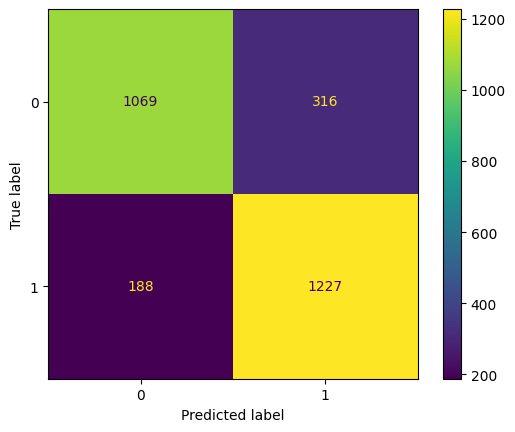

In [48]:
# put your answer here
cm = confusion_matrix(y_validation, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [51]:
# put your answer here
X_test = df_test["text"]
y_test = df_test["label"]
predictions_test = model.predict(vectorizer.transform(X_test))

accuracy_test = accuracy_score(y_test, predictions_test)
balanced_accuracy_test = balanced_accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)

print("Accuracy:",round(100*accuracy_test,2),'%')
print("Balanced accuracy:",round(100*balanced_accuracy_test,2),'%')
print("Precision:", round(100*precision_test,2),'%')

Accuracy: 81.53 %
Balanced accuracy: 81.55 %
Precision: 78.86 %


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [ ]:
# put your answer here

22. Create a confusion matrix using the **test dataset**

In [ ]:
# put your answer here

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [70]:
# put your answer here
nt = pd.Series("kamusta ka")
model.predict(vectorizer.transform(nt))


array([0])

24. Test the model by providing a hate speech input. The model should predict it as 1

In [80]:
# put your answer here
nt = pd.Series("fuck you")
model.predict(vectorizer.transform(nt))

array([1])

In [71]:
nt = pd.Series("ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng")
model.predict(vectorizer.transform(nt))

array([0])

In [81]:
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
model = MultinomialNB(alpha=3)
model.fit(X_train_transformed, y_train)

nt = pd.Series("ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putangina")
model.predict(vectorizer.transform(nt))

array([1])